##  Import libraries

In [16]:
#Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ace_tools_open as tools
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV  # Ensure this import is included
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, make_scorer
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Load the datasets
ewes_path = "ewes.csv"  # Update with your correct file path if necessary
lambs_path = "lambs.csv"  # Update with your correct file path if necessary

ewes_df = pd.read_csv(ewes_path)
lambs_df = pd.read_csv(lambs_path)

## Plot missing data

Upon initial inspection of files, it was clear that there was a lot of missing data, especially for some variables. I thought it important to have accurate information on this, since variables with small sample sizes most likely have to be excluded as they will be less useful for predictions.

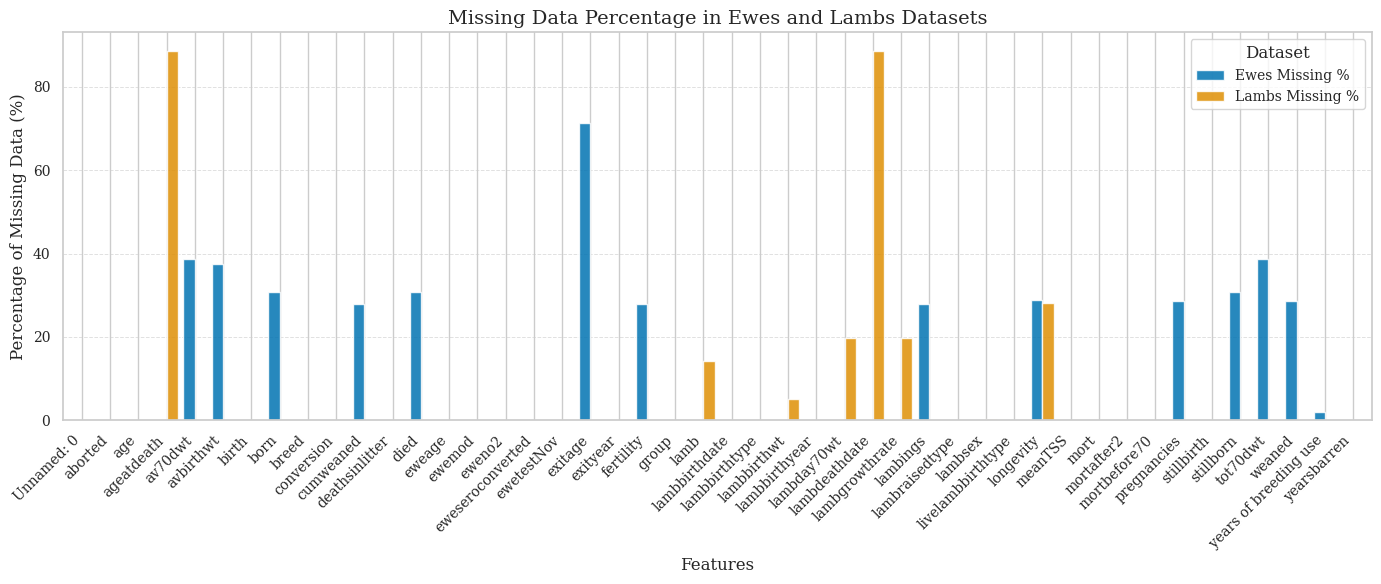

In [6]:
# Set downcasting option and calculate missing percentages in one step
pd.set_option('future.no_silent_downcasting', True)
missing_numeric = pd.DataFrame({
    "Ewes Missing %": ewes_df.isnull().mean() * 100,
    "Lambs Missing %": lambs_df.isnull().mean() * 100
}).fillna("-").replace("-", 0).astype(float)

# Set figure parameters
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 14, "axes.labelsize": 12,
    "legend.fontsize": 10, "xtick.labelsize": 10, "ytick.labelsize": 10,
})

# Plot missing data percentages
fig, ax = plt.subplots(figsize=(14, 6))
colors = sns.color_palette("colorblind", n_colors=len(missing_numeric.columns))
missing_numeric.plot(kind="bar", ax=ax, width=0.8, alpha=0.85, color=colors)
ax.set(title="Missing Data Percentage in Ewes and Lambs Datasets",
       xlabel="Features", ylabel="Percentage of Missing Data (%)")
ax.legend(title="Dataset", fontsize=10, loc="upper right", frameon=True)
ax.set_xticks(range(len(missing_numeric.index)))
ax.set_xticklabels(missing_numeric.index, rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.6)
plt.tight_layout()

# Save high-quality PDF and display plot
plt.savefig("/Users/davidcalleja/Desktop/THESIS/analysis/figures/missing_data_summary.pdf",
            bbox_inches="tight", dpi=600)
plt.show()

## ML models to test individual predictors

In [4]:
# Preprocess data: drop an unwanted column and, if provided, recode the target variable to binary.
def preprocess_data(df, drop_col, target=None, recode_map=None):
    df = df.drop(columns=[drop_col], errors='ignore')
    if target and recode_map:
        df = df.dropna(subset=[target]).copy()
        df[target + '_binary'] = df[target].map(recode_map)
    return df

# Preprocess the ewes and lambs datasets.
ewes_df = preprocess_data(ewes_df, 'Unnamed: 0', 'group', {'minus': 0, 'plus': 1})
lambs_df = preprocess_data(lambs_df, 'Unnamed: 0', 'eweseroconverted', {'never': 0, 'before': 1, 'during': 1})

# Define variables to exclude and a lambda to select valid predictor columns.
excluded_lambs = {"ewemod", "ewetestNov", "lamb", "lambid", "lambbirthdate",
                  "lambdeathdate", "lambsex", "eweseroconverted", "meanTSS"}
excluded_ewes  = {"meanTSS", "conversion", "ewetestNov", "eweseroconverted", "group", "eweno2"}
valid_predictors = lambda df, excl, tgt: [col for col in df.columns if col not in excl and col != tgt]

# Return a model instance based on a string identifier.
def get_model(name):
    return {
        'random_forest': RandomForestClassifier(random_state=42),
        'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
        'xgboost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'knn': KNeighborsClassifier(n_neighbors=5),
        'svm': SVC(random_state=42)
    }.get(name)

# Test predictors for a given model, using hyperparameter tuning via GridSearchCV.
def test_predictors(df, predictors, target, model, param_grid=None):
    if target not in df.columns:
        raise ValueError(f"Target '{target}' not found in DataFrame")
    results = []
    for pred in predictors:
        d = df.dropna(subset=[pred, target]).copy()
        if d[pred].dtype == 'object':
            d[pred] = d[pred].astype('category').cat.codes
        X_train, X_test, y_train, y_test = train_test_split(
            d[[pred]], d[target], test_size=0.2, random_state=42, stratify=d[target]
        )
        if param_grid:
            scorer = make_scorer(recall_score, pos_label=1)
            grid = GridSearchCV(model, param_grid, cv=5, scoring=scorer, n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model, best_params = grid.best_estimator_, grid.best_params_
        else:
            model.fit(X_train, y_train)
            best_model, best_params = model, "N/A"
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred) * 100
        cm = confusion_matrix(y_test, y_pred)
        rec_neg = (cm[0, 0] / cm[0].sum() * 100) if cm[0].sum() else 0
        rec_pos = (cm[1, 1] / cm[1].sum() * 100) if cm[1].sum() else 0
        results.append([pred, len(d), acc, rec_neg, rec_pos, best_params])
    return pd.DataFrame(results, columns=["Predictor", "Sample Size", "Accuracy (%)", 
                                           "Recall for Negative (0) (%)", "Recall for Positive (1) (%)", 
                                           "Best Params"])

# Run model tests for both datasets and display formatted results.
def run_model_test(model_name, display_name, param_grid=None):
    model = get_model(model_name)
    lp = valid_predictors(lambs_df, excluded_lambs, 'eweseroconverted_binary')
    ep = valid_predictors(ewes_df, excluded_ewes, 'group_binary')
    l_res = test_predictors(lambs_df, lp, 'eweseroconverted_binary', model, param_grid)
    e_res = test_predictors(ewes_df, ep, 'group_binary', model, param_grid)
    comb = pd.concat([e_res, l_res], keys=['Ewes', 'Lambs'])
    comb['Model'] = display_name
    comb['Accuracy (%)'] = comb['Accuracy (%)'].map("{:.2f}%".format)
    comb.sort_values(by="Accuracy (%)", ascending=False, inplace=True)
    
    tools.display_dataframe_to_user(name=f"Formatted Ewes - Predictor Performance ({display_name})", dataframe=e_res)
    tools.display_dataframe_to_user(name=f"Formatted Lambs - Predictor Performance ({display_name})", dataframe=l_res)
    
    return comb

# Define hyperparameter grids for each model.
param_grids = {
    'random_forest': {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]},
    'logistic_regression': {'C': [0.1, 1, 10], 'solver': ['liblinear']},
    'xgboost': {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'knn': {'n_neighbors': [3, 5, 7]},
    'svm': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

# Run tests for each model and combine the results.
combined_results_rf  = run_model_test('random_forest',       'Random Forest',       param_grids['random_forest'])
combined_results_lr  = run_model_test('logistic_regression', 'Logistic Regression', param_grids['logistic_regression'])
combined_results_xgb = run_model_test('xgboost',             'XGBoost',             param_grids['xgboost'])
combined_results_knn = run_model_test('knn',                 'K-Nearest Neighbors', param_grids['knn'])
combined_results_svm = run_model_test('svm',                 'Support Vector Machines', param_grids['svm'])

combined_df = pd.concat([
    combined_results_rf, combined_results_lr, combined_results_xgb,
    combined_results_knn, combined_results_svm
])


Formatted Ewes - Predictor Performance (Random Forest)


Formatted Lambs - Predictor Performance (Random Forest)


Formatted Ewes - Predictor Performance (Logistic Regression)


Formatted Lambs - Predictor Performance (Logistic Regression)


Formatted Ewes - Predictor Performance (XGBoost)


Formatted Lambs - Predictor Performance (XGBoost)


Formatted Ewes - Predictor Performance (K-Nearest Neighbors)


Formatted Lambs - Predictor Performance (K-Nearest Neighbors)


Formatted Ewes - Predictor Performance (Support Vector Machines)


Formatted Lambs - Predictor Performance (Support Vector Machines)


## Figures

Visualize predictive power of individual variables as barchart to show actual positive recall numbers and as heatmap since it is easier to understand but has the limitation of being normalized. Additional figure created to show results of hyperparameter optimization. 

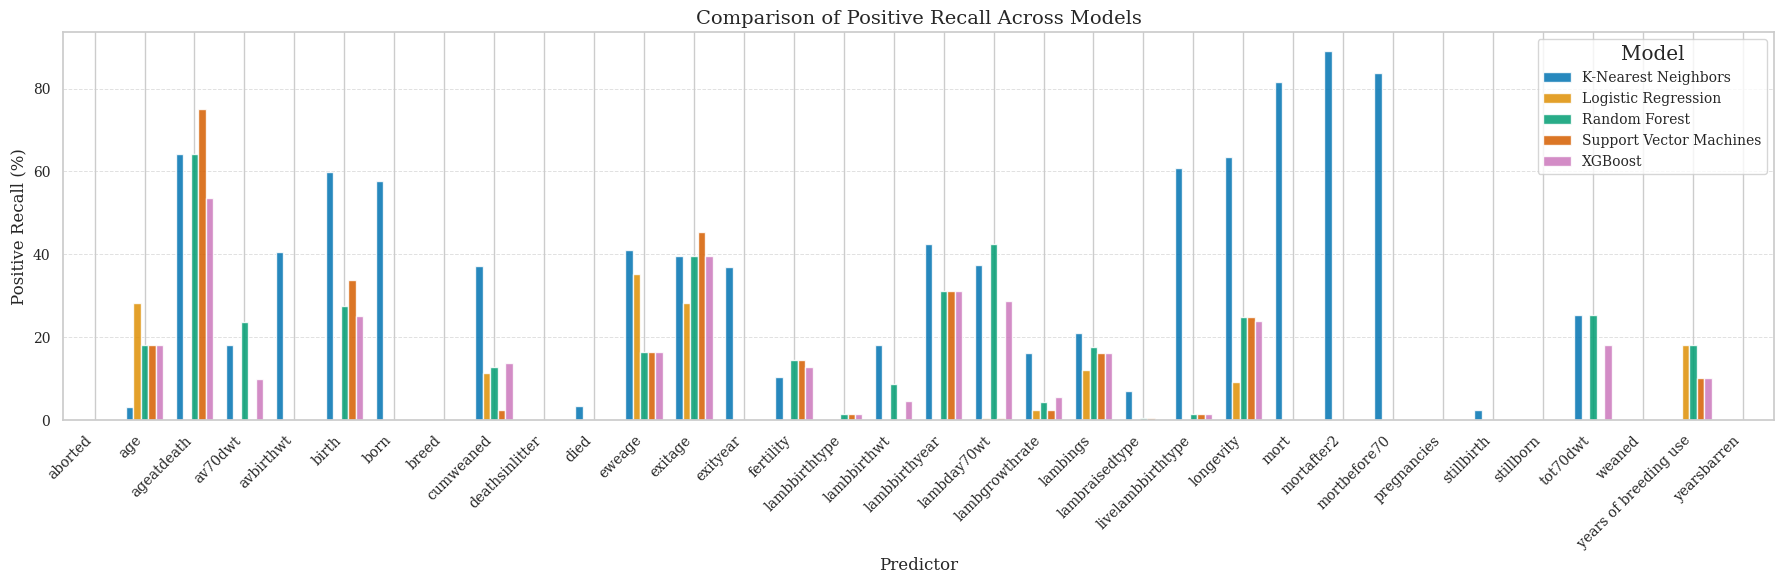

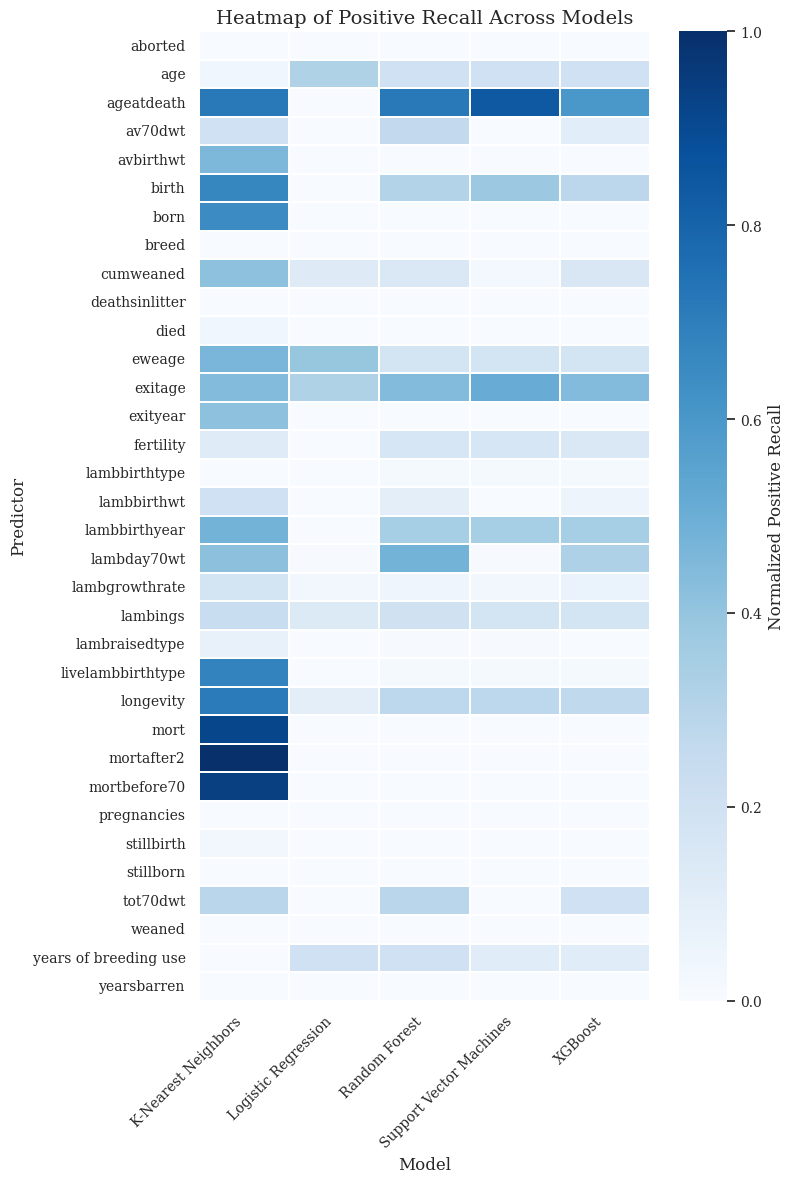

In [11]:
# Create a pivot table of Positive Recall (%) by Predictor and Model.
pivot_table = combined_df.pivot_table(index='Predictor', columns='Model', 
                                        values='Recall for Positive (1) (%)', aggfunc='first')

# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 14, "axes.labelsize": 12,
    "legend.fontsize": 10, "xtick.labelsize": 10, "ytick.labelsize": 10,
})

# Bar plot for model comparison
fig, ax = plt.subplots(figsize=(18, 6))
colors = sns.color_palette("colorblind", n_colors=len(pivot_table.columns))
pivot_table.plot(kind="bar", ax=ax, width=0.75, alpha=0.85, color=colors)
ax.set(title="Comparison of Positive Recall Across Models", xlabel="Predictor", ylabel="Positive Recall (%)")
plt.xticks(rotation=45, ha="right")
ax.legend(title="Model", loc="upper right", frameon=True)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.savefig("/Users/davidcalleja/Desktop/THESIS/analysis/figures/Model_Comparison_Plot.pdf", bbox_inches="tight")
plt.show()

# Normalize data for heatmap (0-1 scale)
norm_data = (pivot_table - pivot_table.min().min()) / (pivot_table.max().max() - pivot_table.min().min())

# Heatmap for normalized positive recall
fig, ax = plt.subplots(figsize=(8, 12))
sns.heatmap(norm_data, cmap="Blues", linewidths=0.01, linecolor="white",
            cbar_kws={"label": "Normalized Positive Recall"}, annot=False, ax=ax)
ax.set(title="Heatmap of Positive Recall Across Models", xlabel="Model", ylabel="Predictor")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/Users/davidcalleja/Desktop/THESIS/analysis/figures/Model_Comparison_Heatmap.pdf", bbox_inches="tight")
plt.show()

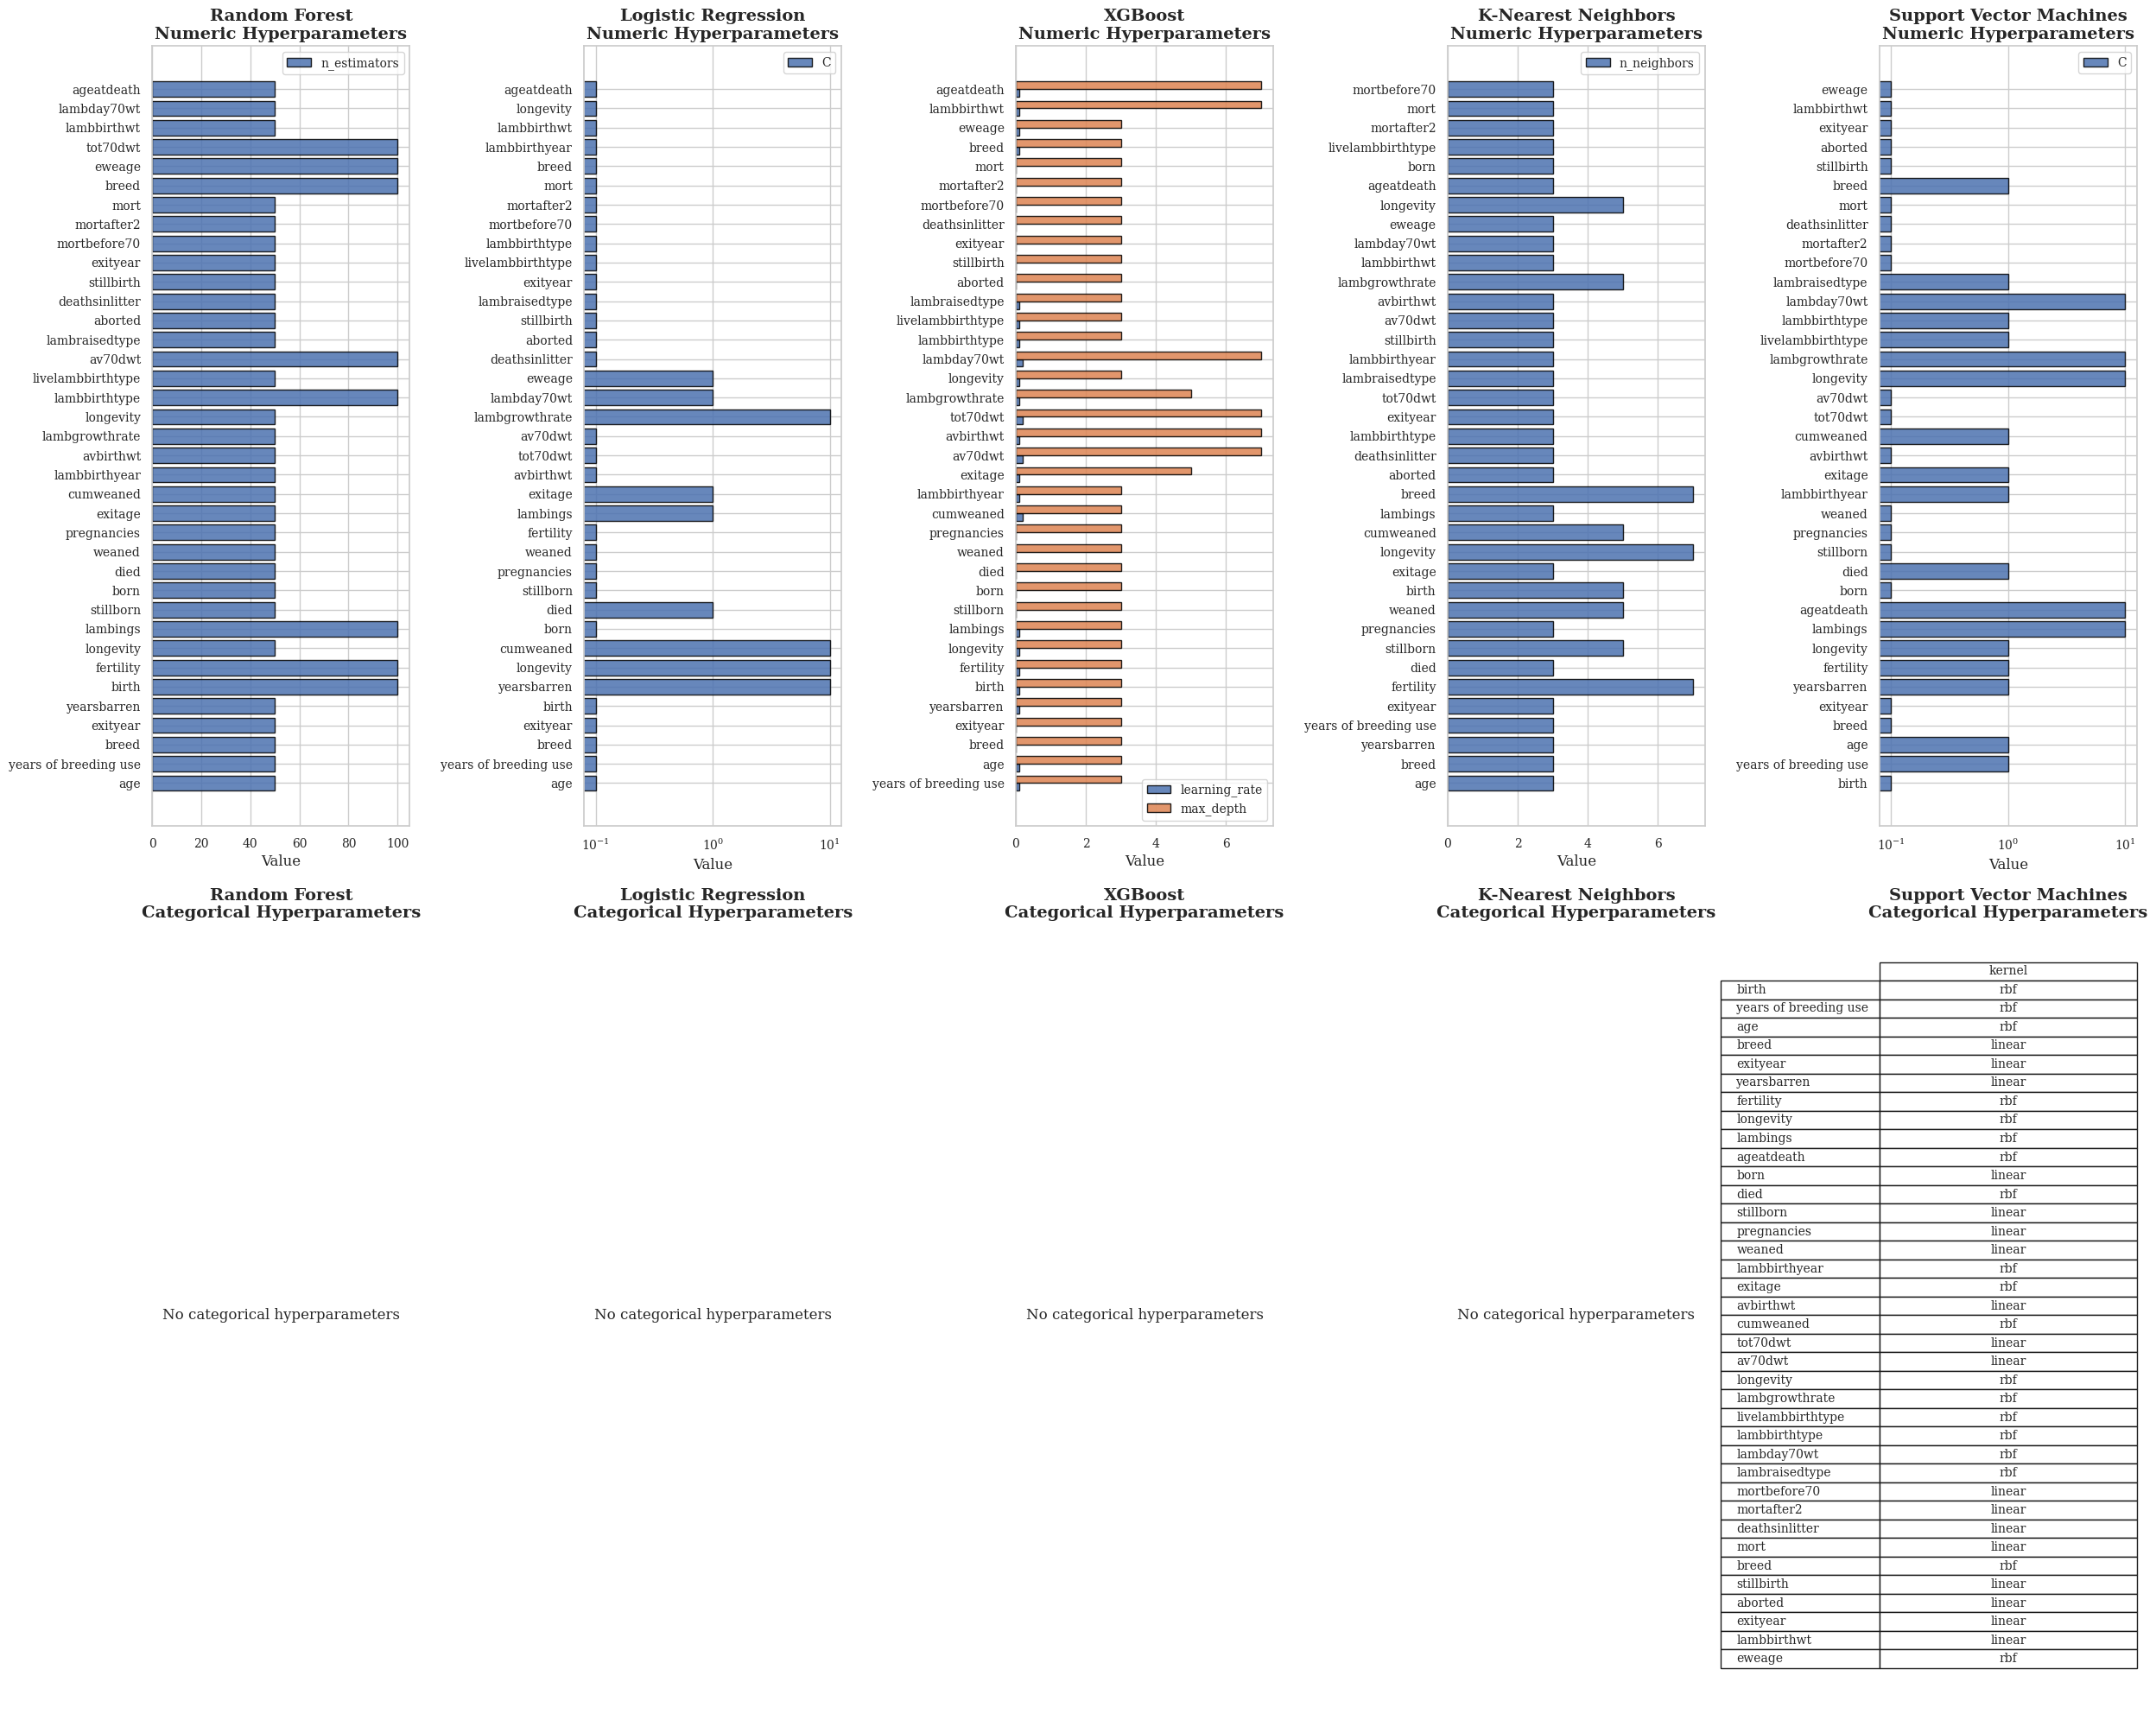

In [18]:
def plot_all_models_hyperparams(combined_df):
    # Get unique model names from the DataFrame.
    models = combined_df["Model"].unique()
    
    # Create a dictionary to store varying hyperparameters for each model.
    # Each model is mapped to two DataFrames: one for numeric and one for categorical parameters.
    model_params = {}
    for model in models:
        # Filter rows corresponding to the current model.
        df_model = combined_df[combined_df["Model"] == model]
        
        # Build a DataFrame of "Best Params" for each predictor.
        # If "Best Params" is not a dict, default to an empty dict.
        params_df = pd.DataFrame(
            [r.get("Best Params", {}) if isinstance(r.get("Best Params", {}), dict) else {}
             for _, r in df_model.iterrows()],
            index=df_model["Predictor"]
        )
        
        # Identify hyperparameters that vary across predictors.
        varying = [col for col in params_df.columns if params_df[col].nunique() > 1]
        if not varying:
            # If no parameters vary, store the full DataFrame as categorical.
            model_params[model] = {"numeric": pd.DataFrame(), "categorical": params_df}
        else:
            # Create a subset DataFrame of only the varying hyperparameters.
            params_vary = params_df[varying].copy()
            numeric_cols = []
            # Try converting each column to numeric to identify numeric hyperparameters.
            for col in varying:
                try:
                    conv = pd.to_numeric(params_vary[col])
                    # If conversion is successful (non-null values exist), treat as numeric.
                    if conv.notnull().sum() > 0:
                        numeric_cols.append(col)
                        params_vary[col] = conv
                except Exception:
                    # If conversion fails, leave column as categorical.
                    pass
            # All columns not identified as numeric are treated as categorical.
            categorical_cols = [col for col in varying if col not in numeric_cols]
            model_params[model] = {
                "numeric": params_vary[numeric_cols] if numeric_cols else pd.DataFrame(),
                "categorical": params_vary[categorical_cols] if categorical_cols else pd.DataFrame()
            }
    
    # Determine the number of models for subplot creation.
    n_models = len(models)
    # Create a figure with 2 rows (numeric on top, categorical below) and one column per model.
    fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 20))
    # Ensure axes is always a 2D array (handles the case of one model).
    if n_models == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    
    # Set common Seaborn theme and plotting parameters.
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({
        "font.family": "serif", "font.size": 12,
        "axes.titlesize": 14, "axes.labelsize": 12,
        "legend.fontsize": 10, "xtick.labelsize": 10, "ytick.labelsize": 10,
    })
    
    # Loop through each model to create its numeric and categorical subplots.
    for j, model in enumerate(models):
        # Retrieve numeric and categorical hyperparameters for this model.
        num_df = model_params[model]["numeric"]
        cat_df = model_params[model]["categorical"]
        ax_num, ax_cat = axes[0, j], axes[1, j]
        
        # --- Plot Numeric Hyperparameters ---
        ax_num.set_title(f"{model}\nNumeric Hyperparameters", fontsize=14, fontweight="bold")
        if not num_df.empty:
            # Get list of predictors and set up horizontal bar positions.
            predictors = num_df.index.tolist()
            x = np.arange(len(predictors))
            n_params = num_df.shape[1]
            width = 0.8 / n_params  # Divide bar width among multiple hyperparameters.
            # Plot each numeric hyperparameter as horizontal bars.
            for i, col in enumerate(num_df.columns):
                vals = num_df[col].reindex(predictors)
                # For hyperparameter 'C', use a logarithmic scale.
                if col.lower() == "c":
                    ax_num.set_xscale("log")
                ax_num.barh(x + i * width, vals.values, height=width,
                            label=col, alpha=0.85, edgecolor="black")
            # Adjust y-axis ticks to align with grouped bars.
            ax_num.set_yticks(x + width * (n_params - 1) / 2)
            ax_num.set_yticklabels(predictors)
            ax_num.set_xlabel("Value")
            ax_num.legend(fontsize=10)
        else:
            # If no numeric hyperparameters vary, display a message.
            ax_num.text(0.5, 0.5, "No numeric hyperparameters vary",
                        ha="center", va="center", fontsize=12)
            ax_num.axis('off')
        
        # --- Plot Categorical Hyperparameters ---
        ax_cat.set_title(f"{model}\nCategorical Hyperparameters", fontsize=14, fontweight="bold")
        if not cat_df.empty:
            # Only keep columns where the categorical parameter varies.
            varying_cat = [col for col in cat_df.columns if cat_df[col].nunique() > 1]
            if varying_cat:
                table_data = cat_df[varying_cat].fillna("").astype(str)
                # Create a table with predictors as rows and hyperparameters as columns.
                table = ax_cat.table(cellText=table_data.values,
                                     rowLabels=table_data.index,
                                     colLabels=table_data.columns,
                                     loc="center", cellLoc="center")
                table.auto_set_font_size(False)
                table.set_fontsize(10)
                ax_cat.axis('off')
            else:
                ax_cat.text(0.5, 0.5, "No categorical hyperparameters vary",
                            ha="center", va="center", fontsize=12)
                ax_cat.axis('off')
        else:
            ax_cat.text(0.5, 0.5, "No categorical hyperparameters",
                        ha="center", va="center", fontsize=12)
            ax_cat.axis('off')
    
    # Adjust layout and save the final figure.
    plt.tight_layout()
    plt.savefig("/Users/davidcalleja/Desktop/THESIS/analysis/figures/Hyperparameter_Tuning_Results.pdf", bbox_inches="tight")
    plt.show()

plot_all_models_hyperparams(combined_df)